# Building a RAG Chatbot

## What is a Chatbot?
- A program designed to simulate conversation with human users.
- They can understand questions and respond with relevant information.

### Types of Chatbots:

- **Rule-Based:** Follows predefined rules and keywords. Limited in scope.  
    *Example:* "If user says 'hello', respond with 'Hi there!'"

- **Retrieval-Based:** Selects the best response from a library of predefined responses.  
    *Example:* FAQ bots that find the most similar question.

- **Generative:** Creates new, original responses using advanced AI models.  
    *Example:* ChatGPT, Gemini. Highly flexible.

### The Challenge: Generative Model Hallucinations
- Pure generative models can sometimes "hallucinate" - making up facts or providing incorrect information.
- They generate responses based on their training data, which might not always align with your specific, current, or proprietary information.

### The Solution: Retrieval-Augmented Generation (RAG)
- RAG combines the strengths of retrieval-based and generative models.
- It allows a Large Language Model (LLM) to generate answers grounded in specific, provided source material.
- Reduces hallucinations and provides more accurate, contextually relevant responses, especially with your own data.


## Requirements

#### Packages

In [24]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


##### PyTorch with CUDA

In [25]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


#### Getting Google API Key
1. https://aistudio.google.com/apikey
2. Create API Key
3. Select/Create project
4. Create API key
5. Copy key into '.env' file: GOOGLE_API_KEY="\<INPUT KEY HERE\>"

#### Loading API keys from '.env' file.
- HuggingFace
- Google (Not vertex)
- Groq

In [26]:
from dotenv import load_dotenv
import os
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
HUGGINGFACEHUB_API_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

## Chatbot #1
### *Simple prompt engineering (Gemini 2.0 flash api)*

In essance a RAG chatbot leverages prompt engineering, primarily through its **system prompt** and **context**, to generate informed responses.
- **System prompt**: Guidelines for how the chatbot should respond.
- **Context**: Relevant information retrieved from external sources, used to ground the chatbot's answers.

<div style="">
    <img src="assets/rag.png" alt="Rag Pipeline" width="60%" style="background-color: white; padding: 10px; border-radius: 5px;">
    <p>Source: <a href="https://www.clarifai.com/blog/what-is-rag-retrieval-augmented-generation">https://www.clarifai.com/blog/what-is-rag-retrieval-augmented-generation</a></p>
</div>

In [27]:
from google import genai
from google.genai import types
from IPython.display import display, Markdown

In [28]:
MODEL_CHAT = "gemini-2.0-flash"
google_client = genai.Client(vertexai=False, api_key=GOOGLE_API_KEY)

Constants

In [29]:
system_prompt = "".join((
    "You are an assistant for question-answering tasks. ",
    "Use the following pieces of retrieved context to answer the question. ",
    "If you don't know the answer, say that you don't know. ",
    "Use three sentences maximum and keep the answer concise.",
))

sample_documents = [
    "Malta wins all olypic competitions in 2024.",
    "The Europa League first qualifying round is played this evening and Malta is being represented by Sirens FC.",
    "The Malta national football team is set to compete in the upcoming UEFA Euro 2024 qualifiers."
    "Italy did not qualify for the UEFA Euro 2024",
    "Germany is the reigning champion of the UEFA Euro 2024.",
    "France is one of the favorites to win the UEFA Euro 2024.",
    "Spain is also a strong contender in the UEFA Euro 2024.",
]

question = "News about Malta national football"

Prompt engineering

In [30]:
sources = "\n".join(sample_documents)

question_and_sources = f"Question: {question}\nContext:\n{sources}"

display(Markdown(f"### **System Prompt**\n```\n{system_prompt}\n```"))
display(Markdown(f"### **User Question and Sources**\n```\n{question_and_sources}\n```"))

### **System Prompt**
```
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, say that you don't know. Use three sentences maximum and keep the answer concise.
```

### **User Question and Sources**
```
Question: News about Malta national football
Context:
Malta wins all olypic competitions in 2024.
The Europa League first qualifying round is played this evening and Malta is being represented by Sirens FC.
The Malta national football team is set to compete in the upcoming UEFA Euro 2024 qualifiers.Italy did not qualify for the UEFA Euro 2024
Germany is the reigning champion of the UEFA Euro 2024.
France is one of the favorites to win the UEFA Euro 2024.
Spain is also a strong contender in the UEFA Euro 2024.
```

In [31]:
# https://github.com/googleapis/python-genai
response = google_client.models.generate_content(
    model=MODEL_CHAT,
    contents=question_and_sources,
    config=types.GenerateContentConfig(
        system_instruction=system_prompt,
        max_output_tokens=300,
        temperature=0.3,
        # safety_settings=[
        #     types.SafetySetting(
        #         category='HARM_CATEGORY_HATE_SPEECH',
        #         threshold='BLOCK_ONLY_HIGH',
        #     )
        # ],
    ),
)
display(Markdown(f"### **Response**\n```\n{response.text}\n```"))

### **Response**
```
The Malta national football team is set to compete in the upcoming UEFA Euro 2024 qualifiers. Sirens FC is representing Malta in the Europa League first qualifying round. Other countries like France and Spain are strong contenders in the UEFA Euro 2024.

```

#### Conversational chatbot

To make your chatbot conversational append its responses to the 'contents' as system messages. Remember, longer histories consume more tokens, so manage chat history carefully.

---
### How can we automate the sources for dynamic chatbot context?

**Retrievers** are the solution for automating dynamic context for our chatbot.

---

## Chatbot #2
### *Adding a retriever (ChromaDB)*

When adding a retriever to a chatbot, the core process, known as Retrieval-Augmented Generation (RAG), involves two main steps:

- **Retrieval**: The retriever searches an external knowledge base for information relevant to the user's query.
- **Generation**: This retrieved information is then fed to the Large Language Model (LLM) as context, allowing it to generate a more accurate and grounded answer.

##### Why Retrievers?
Retrievers bring significant advantages to chatbots, making them far more capable and efficient:
- Automate context/source searching.
- Offer contextually relevant answers.
- Enable easier knowledge updates without retraining the entire model.
- Improve cost-effectiveness.
- Makes chatbot more explainable by providing actual sources.
- Enabled to filter context/sources effectively, thus limiting the token length of an LLM.

<div style="">
    <img src="assets/retrievers.png" alt="Vector database Pipeline" width="75%" style="background-color: white; padding: 10px; border-radius: 5px;">
    <p>Source: <a href="https://www.clarifai.com/blog/what-is-rag-retrieval-augmented-generation">https://www.clarifai.com/blog/what-is-rag-retrieval-augmented-generation</a></p>
</div>

##### How Do Retrievers Work?

Retrievers primarily work by:
- **Chunking**: Breaking down large documents into smaller, manageable pieces (chunks).
- **Embeddings**: Converting these chunks (and query) into numerical representations (vectors) using embedding models.
- **Datastore**: Storing these embedded chunks in a specialised database (like a vector database) for fast searching.

When a query comes in, its embedding is compared to the stored chunk embeddings to find the most similar (relevant) chunks. This search can be:
- **Semantic**: Based on the meaning or context of the words.
- **Syntactic**: Based on keyword matching or exact phrases.
- **Hybrid**: Combining both semantic and syntactic approaches for comprehensive results.

The retriever then calculates similarity scores between the query and the chunks. It retrieves the most relevant chunks by either:
- Selecting the **top-k** (e.g., top 3, top 5) most similar chunks.
- Applying a **threshold** to the **similarity score**, only retrieving chunks that exceed a certain relevance level.

<!-- Add other databases, emebdding models, chunking -->

#### Creating database using ChromaDB & Nomic Emebeddings. (No chunking)

Requirements

In [32]:
from sentence_transformers import SentenceTransformer
import chromadb
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Creating Persistent ChromaDB

In [33]:
COLLECTION_NAME = "malta_news"
CHROMADB_PATH = "data/chromadb"

chroma_client = chromadb.PersistentClient(path=CHROMADB_PATH)
collection = chroma_client.get_or_create_collection(name=COLLECTION_NAME)

Initialising Nomic embedding model (Text to numerical respresentation)

In [34]:
MODEL_EMBEDDING = "nomic-ai/nomic-embed-text-v1"
embedding_model = SentenceTransformer(MODEL_EMBEDDING, trust_remote_code=True, device=device)

<All keys matched successfully>


Embedding the document texts for similarity matching

In [35]:
# Embedding the documents

embeddings = embedding_model.encode(
    sample_documents,
    device=device,
    # batch_size=EMBEDDING_BATCH_SIZE,
    show_progress_bar=True,
    normalize_embeddings=True,
    # task_type='search_document', # Uncomment if your model requires a specific task type
).tolist()

len(embeddings)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

6

Adding documents into ChromaDB

In [36]:
# Adding to chroma collection
# Each document contains: id, embedding, documents, and metadata

num_docs = len(sample_documents)
collection.add(
    ids=[f"doc_{i}" for i in range(num_docs)],
    embeddings=embeddings,
    documents=sample_documents,
    metadatas=[{"source": "malta_news", "id": f"doc_{i}"} for i in range(num_docs)],
)
# 'add' will not overwrite existing documents with the same IDs.
# If you want to overwrite existing documents, use `upsert` instead of `add`.

# Show the number of documents in the collection
collection.count()

6

Format output of chromadb

In [37]:
def format_document_results(results):
    formatted = []
    docs = results['documents'][0]
    metadatas = results['metadatas'][0]
    scores = results.get('distances', [[None]*len(docs)])[0]
    for idx, (doc, metadata, score) in enumerate(zip(docs, metadatas, scores)):
        formatted.append(
            f"{idx}: {doc} (Source: ID: {metadata['id']}, Score: {score:.4f})"
        )
    return "\n".join(formatted)

Semantic search (Cosine Similarity)

In [38]:
# Embedding the question and querying the collection
question_embeddings = embedding_model.encode(
    question,
    device=device,
    normalize_embeddings=True,
).tolist()

# Querying the collection
document_results = collection.query(
    query_embeddings=question_embeddings,
    n_results=2,
    # include=["documents", "metadatas"]
)

display(Markdown(f"### **Query**\n```\n{question}\n```"))
display(Markdown(f"### **Results**\n```\n{format_document_results(document_results)}\n```"))

### **Query**
```
News about Malta national football
```

### **Results**
```
0: The Malta national football team is set to compete in the upcoming UEFA Euro 2024 qualifiers. (Source: ID: doc_2, Score: 0.5045)
1: The Europa League first qualifying round is played this evening and Malta is being represented by Sirens FC. (Source: ID: doc_1, Score: 0.7072)
```

#### Combing Retrieval and LLM

In [39]:
# Retrieval
document_results = collection.query(
    query_embeddings=question_embeddings,
    n_results=2,
    # include=["documents", "metadatas"]
)
document_texts = document_results['documents'][0]
documents_str = "\n".join(document_texts)

# Prompt engineering
question_and_sources = f"Question: {question}\nContexts:\n{documents_str}"

# LLM
response = google_client.models.generate_content(
    model=MODEL_CHAT,
    contents=question_and_sources,
    config=types.GenerateContentConfig(
        system_instruction=system_prompt,
        max_output_tokens=300,
        temperature=0.3,
        # safety_settings=[
        #     types.SafetySetting(
        #         category='HARM_CATEGORY_HATE_SPEECH',
        #         threshold='BLOCK_ONLY_HIGH',
        #     )
        # ],
    ),
)

# Prints
display(Markdown(f"### **System Prompt**\n```\n{system_prompt}\n```"))
display(Markdown(f"### **User Question and Sources**\n```\n{question_and_sources}\n```"))
display(Markdown(f"### **Response**\n```\n{response.text}\n```"))

### **System Prompt**
```
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, say that you don't know. Use three sentences maximum and keep the answer concise.
```

### **User Question and Sources**
```
Question: News about Malta national football
Contexts:
The Malta national football team is set to compete in the upcoming UEFA Euro 2024 qualifiers.
The Europa League first qualifying round is played this evening and Malta is being represented by Sirens FC.
```

### **Response**
```
The Malta national football team is set to compete in the upcoming UEFA Euro 2024 qualifiers. Sirens FC is representing Malta in the Europa League first qualifying round.

```

---
### Can we streamline the entire pipeline?

Streamlining the RAG chatbot pipeline is crucial for improving performance and scalability, ensuring chatbots can efficiently provide accurate, real-time information. 

---

## Chatbot #3
### *Streamlining with LangChain and LangGraph*

**LangChain** is a modular framework for building complex AI workflows, while **LangGraph** extends LangChain by providing a graph-based, stateful approach to orchestrating workflows, particularly for agentic AI patterns involving cyclical workflows.

Requirements

In [40]:
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langgraph.prebuilt import ToolNode, create_react_agent
from langgraph.checkpoint.memory import MemorySaver

Creating langgraph pipeline.

Note that Chromadb still requires pre-processing of raw document texts and embeddings.

In [41]:
# LLM
llm = init_chat_model(
    MODEL_CHAT,
    model_provider="google_genai",
    temperature=0.7,
)

# -- Retrieval tool --

# Embedding model with langchain
embedding_model = HuggingFaceEmbeddings(
    model_name=MODEL_EMBEDDING,
    model_kwargs={"device": device, "trust_remote_code": True},
)

# Chroma database with langchain
vector_store = Chroma(
    persist_directory=CHROMADB_PATH,
    embedding_function=embedding_model,
    collection_name=COLLECTION_NAME,
)

# Setting up function tool for retrieval
def retrieve_tool(query: str):
    """Search a high-quality knowledge base for facts relevant to the user's query."""

    # Search documents using chromadb vector store
    vector_store_result = vector_store.similarity_search_with_score(
        query,
        k=2,  # Number of documents to retrieve
    )
    # Format the results
    retrieved_docs_with_scores = [(document, float(score)) for (document, score) in vector_store_result]

    # Get string for prompt engineering
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc, score in retrieved_docs_with_scores
    )

    return serialized, retrieved_docs_with_scores

# Creating tool with retrieve function. Note that other tools can be added to the ToolNode.
tools = ToolNode([tool(response_format="content_and_artifact")(retrieve_tool)])

# Memory for chat history and conversational context
memory = MemorySaver()

agent = create_react_agent(llm, tools, checkpointer=memory, prompt=system_prompt)

<All keys matched successfully>


Showing Graph

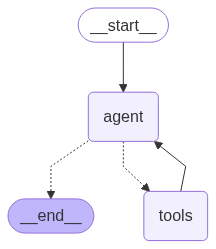

In [42]:
from IPython.display import Image, display
image_data = agent.get_graph().draw_mermaid_png()
with open("assets/graph.png", "wb") as f:
    f.write(image_data)
display(Image("assets/graph.png"))

In [43]:
input_message = question

for event in agent.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config={"configurable": {"thread_id": "test"}},
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

News about Malta national football
================================== Ai Message ==================================
Tool Calls:
  retrieve_tool (a821044a-40d5-4ef4-adc6-12042c1336fd)
 Call ID: a821044a-40d5-4ef4-adc6-12042c1336fd
  Args:
    query: News about Malta national football team
================================= Tool Message =================================
Name: retrieve_tool

Source: {'id': 'doc_2', 'source': 'malta_news'}
Content: The Malta national football team is set to compete in the upcoming UEFA Euro 2024 qualifiers.

Source: {'id': 'doc_1', 'source': 'malta_news'}
Content: The Europa League first qualifying round is played this evening and Malta is being represented by Sirens FC.
================================== Ai Message ==================================

The Malta national football team is set to compete in the upcoming UEFA Euro 2024 qualifiers. Additionally, Sirens FC will repr

### Benefits of LangChain & LangGraph
- Formatted and algined input/output
- Automatic pipelining management
- Advanced tool calling:
    - Multiple retrieval calls.
    - Fine-tuning of retrieval queries.
    - Intelligent recognition of unnecessary retrieval calls, leading to cost and time savings.
- Observability and Debugging

---

### Is logging an option, and can we track model costs?

Logging helps a lot for identifying user questions, retrieved documents, LLM responses, tool calls, latency, and errors. This data is vital for debugging, performance monitoring, and improving the chatbot's accuracy and relevance.

---

## Chatbot #4

### *Adding Tracing (Langfuse)*

#### What is Langfuse?

Langfuse is an open-source platform designed to observe and evaluate large language model (LLM) applications. This is used to trace the flow of information from the user query through retrieval, generation, and ultimately to the chatbot's response. It is beneficial because it provides visibility into the "black box" of LLM interactions, helping identify bottlenecks or errors in the RAG pipeline, such as poor retrieval results or hallucination.

Langfuse also allows local deployment rather than using cloud services due to costs.

#### How to deploy langfuse locally?

1. Download and install docker [Docker](https://www.docker.com/).
2. Ensure git is installed (or download the repository directly).
3. Run the below commands:

```bash
git clone https://github.com/langfuse/langfuse.git
cd langfuse
docker compose up
```

4. View the website at ```http://localhost:3000```
5. Navigate to Settings/API Keys, 'Create new API keys'

![Langfuse API Keys](assets/langfuse.png)

Please note that langfuse is currently being updated and different code may be need to integrate the system depending on the versions.
- Pip langfuse verion: 2.60.4
- Docker langfuse version: 3.54.0

Adding tracing to the chatbot

In [ ]:
from langfuse.callback import CallbackHandler

langfuse_handler  = CallbackHandler(
  secret_key="sk-lf-46ff8cdc-ccd8-4b74-8c4c-94c83ab58a29",
  public_key="pk-lf-3a4eaa29-9ec1-4f47-b517-4f58be7bc0d2",
  host="http://localhost:3000"
)

Chatbot remains the same, just 1 line change for config to include the langfuse callback.

In [ ]:
input_message = question

for event in agent.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config={
        "configurable": {"thread_id": "test"}, 
        "callbacks": [langfuse_handler]  # Added langfuse handler to the stream
    },
):
    event["messages"][-1].pretty_print()